# Exploratory Data Analysis (EDA) - Data Science

- Steps:
    - Understand the dataset - assess the quality of the dataset
    - Distribute of the dataset - How does the data look like?
    - Correlactions - Find patterns in the dataset

In [102]:
###############################################################
################### DATA CLEANING #############################
###############################################################

In [103]:
#!pip install pandas-profiling

In [104]:
import pandas                   as pd
import sys
import itertools
from collections               import Counter
import numpy                   as np
import gc # Garbage Collector interface
import feather
import time
from datetime                  import datetime
import matplotlib.pyplot       as plt
import seaborn                 as sns
from sklearn.feature_selection import mutual_info_classif
import plotly.express          as ex
from matplotlib                import pyplot

from sklearn.preprocessing     import OneHotEncoder
from sklearn.preprocessing     import LabelEncoder

from pandas_profiling          import ProfileReport

# Normality tests
from scipy.stats import normaltest

%matplotlib inline

pd.set_option('max_columns', 120)
pd.set_option('max_colwidth', 5000)

plt.rcParams['figure.figsize'] = (20, 20)

##### >>> https://towardsdatascience.com/a-straightforward-guide-to-cleaning-and-preparing-data-in-python-8c82f209ae33
# source dataset: https://www.dataquest.io/blog/machine-learning-preparing-data/

# data cleaning - sources
# https://medium.com/sciforce/data-cleaning-and-preprocessing-for-beginners-25748ee00743
# https://medium.com/bitgrit-data-science-publication/data-cleaning-with-python-f6bc3da64e45
# https://towardsdatascience.com/the-ultimate-guide-to-data-cleaning-3969843991d4
# https://towardsdatascience.com/data-cleaning-and-feature-engineering-the-underestimated-parts-of-machine-learning-10681dae4cf7

# Pandas has a high consume of memory RAM usage
# release memory RAM
def release_memory(df):   
    del df
    gc.collect() 
    df = pd.DataFrame() # point to NULL
    print('memory RAM released.')

# Get start time 
start_time = time.time()

# datetime object containing current date and time
now = datetime.now()

# dd/mm/YY H:M:S
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print(">>> date: ", dt_string)

>>> date:  08/08/2021 21:04:17


## Quick Dataset Overview

In [105]:
# dataframe - df
# read csv file, the columns are separated (sep) by ','
df = pd.read_csv('../data/lending_club_loans_2007_2011.csv', skiprows=1, low_memory=False)

half_count = len(df) / 2
df = df.dropna(thresh=half_count,axis=1) # Drop any column with more than 50% missing values
df = df.drop(['url','desc'],axis=1) # These columns are not useful for our purposes

df

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,735.0,739.0,1.0,3.0,0.0,13648.0,83.7%,9.0,f,0.00,0.00,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-2015,171.62,Sep-2016,744.0,740.0,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,car,bike,309xx,GA,1.00,0.0,Apr-1999,740.0,744.0,5.0,3.0,0.0,1687.0,9.4%,4.0,f,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-2013,119.66,Sep-2016,499.0,0.0,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,735.0,739.0,2.0,2.0,0.0,2956.0,98.5%,10.0,f,0.00,0.00,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-2014,649.91,Sep-2016,719.0,715.0,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
3,1076863,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,other,personel,917xx,CA,20.00,0.0,Feb-1996,690.0,694.0,1.0,10.0,0.0,5598.0,21%,37.0,f,0.00,0.00,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,Jan-2015,357.48,Apr-2016,604.0,600.0,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
4,1075358,1311748.0,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,Current,n,other,Personal,972xx,OR,17.94,0.0,Jan-1996,695.0,699.0,0.0,15.0,0.0,27783.0,53.9%,38.0,f,270.78,270.78,3784.490000,3784.49,2729.22,1055.27,0.00,0.00,0.00,Sep-2016,67.79,Sep-2016,694.0,690.0,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42533,72176,70868.0,2525.0,2525.0,225.0,36 months,9.33%,80.69,B,B3,NaN,< 1 year,RENT,110000.0,Not Verified,Jun-2007,Does not meet the credit policy. Status:Fully Paid,n,other,Car repair bill,100xx,NY,10.00,NaN,NaN,710.0,714.0,NaN,NaN,NaN,0.0,NaN,NaN,f,0.00,0.00,2904.498829,258.82,2525.00,379.50,0.00,0.00,0.00,Jun-2010,82.03,May-2007,714.0,710.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,NaN,NaN
42534,71623,70735.0,6500.0,6500.0,0.0,36 months,8.38%,204.84,A,A5,NaN,< 1 year,NONE,NaN,Not Verified,Jun-2007,Does not meet the credit policy. Status:Fully Paid,n,other,Buying a car,100xx,NY,4.00,NaN,NaN,740.0,744.0,NaN,NaN,NaN,0.0,NaN,NaN,f,0.00,0.00,7373.904962,0.00,6500.00,873.90,0.00,0.00,0.00,Jun-2010,205.32,Aug-2007,724.0,720.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,NaN,NaN
42535,70686,70681.0,5000.0,5000.0,0.0,36 months,7.75%,156.11,A,A3,Homemaker,10+ years,MORTGAGE,70000.0,Not Verified,Jun-2007,Does not meet the credit policy. Status:Fully Paid,n,other,Aroundthehouse,068xx,CT,8.81,NaN,NaN,770.0,774.0,NaN,NaN,NaN,0.0,NaN,NaN,f,0.00,0.00,5619.762090,0.00,5000.00,619.76,0.00,0.00,0.00,Jun-2010,156.39,Feb-2015,794.0,790.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,NaN,NaN
42536,Total amount funded in policy code 1:

In [106]:
print(f'Number of rows.....................: {df.shape[0]}')
print(f'Number of columns..................: {df.shape[1]}')

Number of rows.....................: 42538
Number of columns..................: 56


In [107]:
# % of rows missing in each column
list_columns_nan = list()

for column in df.columns:
    percentage = df[column].isnull().mean()
    if(percentage != 0):
        print(f'{column}: {round(percentage*100, 2)}%')
        list_columns_nan.append(column)

member_id: 0.01%
loan_amnt: 0.01%
funded_amnt: 0.01%
funded_amnt_inv: 0.01%
term: 0.01%
int_rate: 0.01%
installment: 0.01%
grade: 0.01%
sub_grade: 0.01%
emp_title: 6.18%
emp_length: 2.62%
home_ownership: 0.01%
annual_inc: 0.02%
verification_status: 0.01%
issue_d: 0.01%
loan_status: 0.01%
pymnt_plan: 0.01%
purpose: 0.01%
title: 0.04%
zip_code: 0.01%
addr_state: 0.01%
dti: 0.01%
delinq_2yrs: 0.08%
earliest_cr_line: 0.08%
fico_range_low: 0.01%
fico_range_high: 0.01%
inq_last_6mths: 0.08%
open_acc: 0.08%
pub_rec: 0.08%
revol_bal: 0.01%
revol_util: 0.22%
total_acc: 0.08%
initial_list_status: 0.01%
out_prncp: 0.01%
out_prncp_inv: 0.01%
total_pymnt: 0.01%
total_pymnt_inv: 0.01%
total_rec_prncp: 0.01%
total_rec_int: 0.01%
total_rec_late_fee: 0.01%
recoveries: 0.01%
collection_recovery_fee: 0.01%
last_pymnt_d: 0.2%
last_pymnt_amnt: 0.01%
last_credit_pull_d: 0.02%
last_fico_range_high: 0.01%
last_fico_range_low: 0.01%
collections_12_mths_ex_med: 0.35%
policy_code: 0.01%
application_type: 0.01%
a

## Identify Missing Data

In [108]:
# count NaN found in the dataset
df.isna().sum()

id                               0
member_id                        3
loan_amnt                        3
funded_amnt                      3
funded_amnt_inv                  3
term                             3
int_rate                         3
installment                      3
grade                            3
sub_grade                        3
emp_title                     2629
emp_length                    1115
home_ownership                   3
annual_inc                       7
verification_status              3
issue_d                          3
loan_status                      3
pymnt_plan                       3
purpose                          3
title                           16
zip_code                         3
addr_state                       3
dti                              3
delinq_2yrs                     32
earliest_cr_line                32
fico_range_low                   3
fico_range_high                  3
inq_last_6mths                  32
open_acc            

## Missing value per feature - heatmap

<AxesSubplot:title={'center':'Missing Values Per Feature'}>

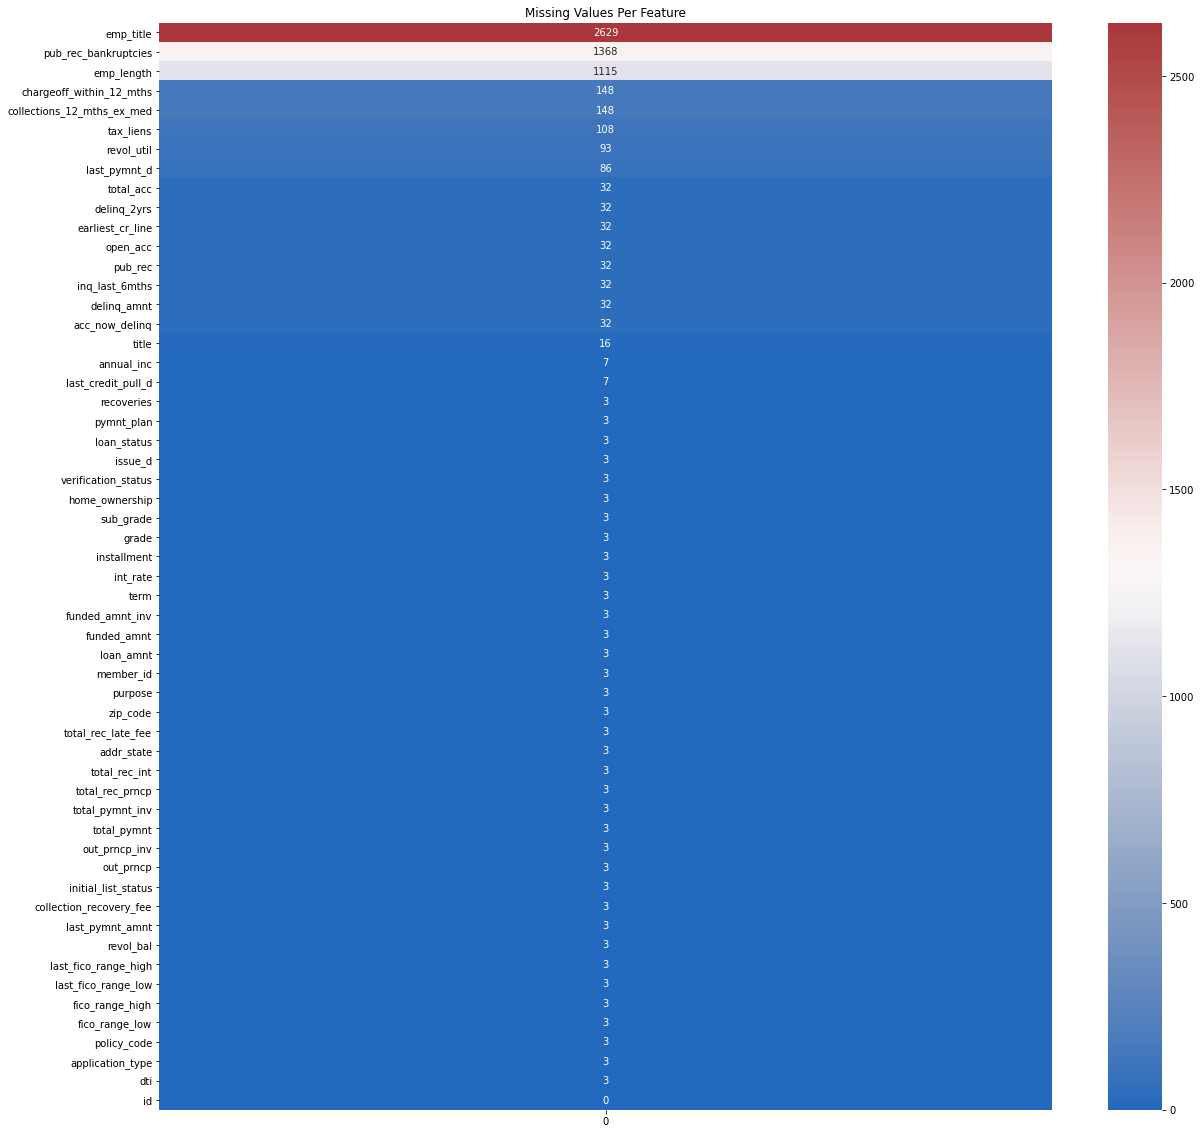

In [109]:
# heatmap - give a big picture of the missing values on the dataset.
plt.title('Missing Values Per Feature')
nans = df.isna().sum().sort_values(ascending=False).to_frame() # get NaN
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag') # seaborn

In [110]:
#df = df.dropna() # drop rows with NaN's
df.shape

(42538, 56)

In [111]:
# remove rows with missing data
#df = df.dropna()

# drop a column
# df.drop('column_name', axis=1)

#half_count = len(df) / 2  # 50% of the dataset
#df = df.dropna(thresh=half_count,axis=1) # Drop any column with more than 50% missing values

# Replace it by the mean, median or mode

In [112]:
df[list_columns_nan].head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,735.0,739.0,1.0,3.0,0.0,13648.0,83.7%,9.0,f,0.00,0.00,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-2015,171.62,Sep-2016,744.0,740.0,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
1,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,car,bike,309xx,GA,1.00,0.0,Apr-1999,740.0,744.0,5.0,3.0,0.0,1687.0,9.4%,4.0,f,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-2013,119.66,Sep-2016,499.0,0.0,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
2,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,735.0,739.0,2.0,2.0,0.0,2956.0,98.5%,10.0,f,0.00,0.00,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-2014,649.91,Sep-2016,719.0,715.0,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
3,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,other,personel,917xx,CA,20.00,0.0,Feb-1996,690.0,694.0,1.0,10.0,0.0,5598.0,21%,37.0,f,0.00,0.00,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,Jan-2015,357.48,Apr-2016,604.0,600.0,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
4,1311748.0,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,Current,n,other,Personal,972xx,OR,17.94,0.0,Jan-1996,695.0,699.0,0.0,15.0,0.0,27783.0,53.9%,38.0,f,270.78,270.78,3784.490000,3784.49,2729.22,1055.27,0.00,0.00,0.00,Sep-2016,67.79,Sep-2016,694.0,690.0,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0


In [113]:
# remove a special character on dataframe
df['revol_util'] = df['revol_util'].str.replace('%', '')
df['int_rate'] = df['int_rate'].str.replace('%', '')

# Convert object to float
df[['revol_util','int_rate']] = df[['revol_util','int_rate']].astype(float)

# convert obejcto category
list_cat = ['last_pymnt_d', 'last_credit_pull_d']

for ilist in list_cat:
    df[f'{ilist}'] = df[f'{ilist}'].astype('category')

In [114]:
df[list_cat]

,last_pymnt_d,last_credit_pull_d
0,Jan-2015,Sep-2016
1,Apr-2013,Sep-2016
2,Jun-2014,Sep-2016
3,Jan-2015,Apr-2016
4,Sep-2016,Sep-2016
...,...,...
42533,Jun-2010,May-2007
42534,Jun-2010,Aug-2007
42535,Jun-2010,Feb-2015
42536,NaN,NaN


In [115]:
df[list_columns_nan].dtypes

member_id                      float64
loan_amnt                      float64
funded_amnt                    float64
funded_amnt_inv                float64
term                            object
int_rate                       float64
installment                    float64
grade                           object
sub_grade                       object
emp_title                       object
emp_length                      object
home_ownership                  object
annual_inc                     float64
verification_status             object
issue_d                         object
loan_status                     object
pymnt_plan                      object
purpose                         object
title                           object
zip_code                        object
addr_state                      object
dti                            float64
delinq_2yrs                    float64
earliest_cr_line                object
fico_range_low                 float64
fico_range_high          

In [116]:
# the mode replaces categorical data.
#mode = ''.join(df['emp_length'].mode())
#df['emp_length'].fillna(mode, inplace=True)

# datetime
#list_datetime = ['last_pymnt_d', 'last_credit_pull_d']

#for ilist in list_datetime:
#    mode = ''.join(df[f'{ilist}'].mode())
#    df[f'{ilist}'].fillna(mode, inplace=True)


# list columns float
#list_impute_mean = ['revol_util',
#                    'collections_12_mths_ex_med',
#                    'chargeoff_within_12_mths',
#                    'pub_rec_bankruptcies',
#                    'tax_liens'
#                   ]

# impute mean to missing values
#df = df.fillna(df[list_impute_mean].mean())

## Target 

In [117]:
df_target = df['loan_status'].value_counts(normalize=True).map('{:.2%}'.format)
df_target = dict(df_target)
df_target

{'Fully Paid': '78.96%',
 'Charged Off': '13.29%',
 'Does not meet the credit policy. Status:Fully Paid': '4.67%',
 'Does not meet the credit policy. Status:Charged Off': '1.79%',
 'Current': '1.21%',
 'In Grace Period': '0.04%',
 'Late (31-120 days)': '0.03%',
 'Late (16-30 days)': '0.01%',
 'Default': '0.00%'}

In [118]:
df.shape

(42538, 56)

In [119]:
list_drop_target = ['Late (31-120 days)',
             'Current',
             'Late (16-30 days)',
             'In Grace Period',
             'Default',
             'Does not meet the credit policy. Status:Fully Paid',
             'Does not meet the credit policy. Status:Charged Off'
            ]

for drop_target in list_drop_target:
    index_drop_target = df[ (df['loan_status'] == f'{drop_target}')].index
    df.drop(index_drop_target, inplace = True)

df.shape

(39242, 56)

In [120]:
df['loan_status'].value_counts(normalize=True).map('{:.2%}'.format)

Fully Paid     85.59%
Charged Off    14.41%
Name: loan_status, dtype: object

In [121]:
df_tar = pd.DataFrame([df_target])
df_tar

list_col = list(df_tar.columns)

for col in list_col:
    df_tar[f'{col}'] = df_tar[f'{col}'].str.replace('%', '')

df_tar[df_tar.select_dtypes(['object']).columns] = df_tar.select_dtypes(['object']).apply(lambda x: x.astype('float64'))
df_tar.dtypes

Fully Paid                                             float64
Charged Off                                            float64
Does not meet the credit policy. Status:Fully Paid     float64
Does not meet the credit policy. Status:Charged Off    float64
Current                                                float64
In Grace Period                                        float64
Late (31-120 days)                                     float64
Late (16-30 days)                                      float64
Default                                                float64
dtype: object

In [122]:
#df['loan_status'].value_counts().plot(kind='pie')

## Visualizing the Target Column Outcomes

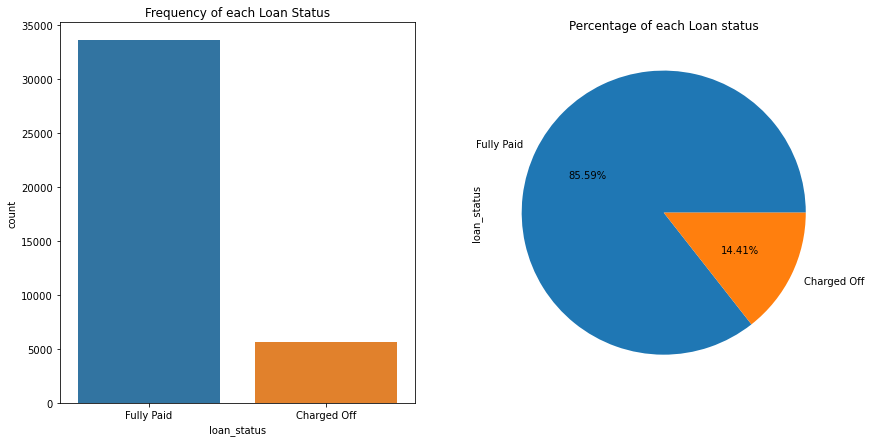

In [123]:
fig, axs = plt.subplots(1,2,figsize=(14,7))

sns.countplot(x='loan_status',data=df,ax=axs[0])
axs[0].set_title("Frequency of each Loan Status")
df['loan_status'].value_counts().plot(x=None,y=None, kind='pie', ax=axs[1],autopct='%1.2f%%')
axs[1].set_title("Percentage of each Loan status")
plt.savefig('pictures/target_stat.png')
plt.show()


In [124]:
#df[list_columns_nan].dtypes

In [125]:
print(df['fico_range_low'].unique())
print(df['fico_range_high'].unique())

[735. 740. 690. 730. 660. 675. 725. 695. 710. 705. 720. 665. 670. 760.
 685. 755. 680. 700. 790. 750. 715. 765. 745. 770. 780. 775. 795. 810.
 800. 815. 785. 805. 825. 820. 630. 625.  nan]
[739. 744. 694. 734. 664. 679. 729. 699. 714. 709. 724. 669. 674. 764.
 689. 759. 684. 704. 794. 754. 719. 769. 749. 774. 784. 779. 799. 814.
 804. 819. 789. 809. 829. 824. 634. 629.  nan]


## Convert Feature (type: object) to Category

In [126]:
df[df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).apply(lambda x: x.astype('category'))

In [127]:
# instantiate labelencoder object
le = LabelEncoder()
categorical_cols = list(df.select_dtypes(['category']))

# apply le on categorical feature columns
df[categorical_cols] = df[categorical_cols].apply(lambda col: le.fit_transform(col))

39242
39239


<AxesSubplot:ylabel='Frequency'>

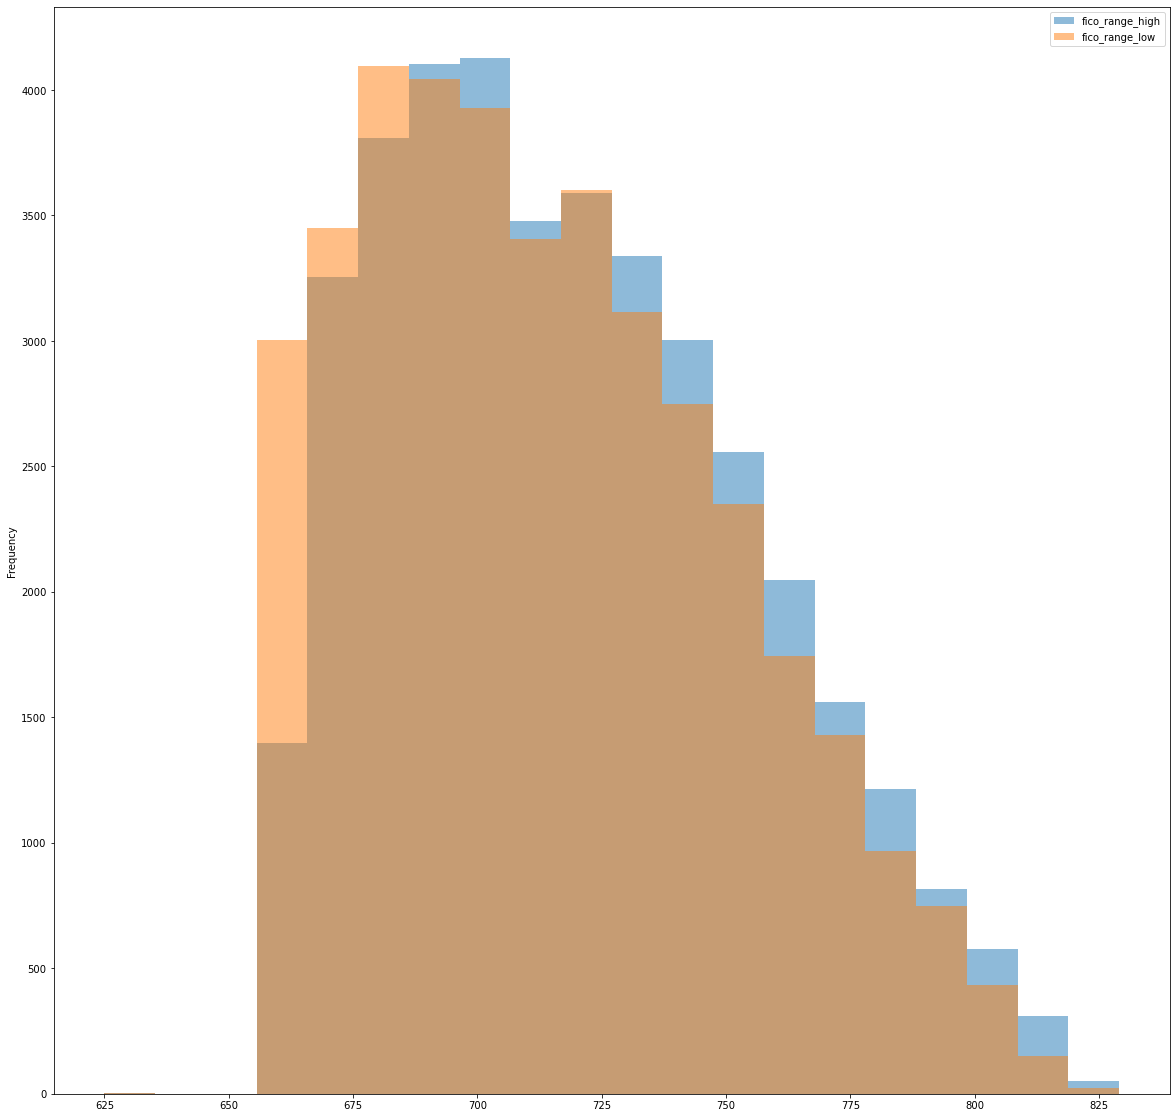

In [128]:
fico_columns = ['fico_range_high','fico_range_low']

print(df.shape[0])

df.dropna(subset=fico_columns,inplace=True)
print(df.shape[0])

df[fico_columns].plot.hist(alpha=0.5,bins=20)

In [129]:
df

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,4080,1296599.0,5000.0,5000.0,4975.0,0,10.65,162.87,1,6,28467,1,4,24000.0,2,13,1,0,1,2937,712,3,27.65,0.0,191,735.0,739.0,1.0,3.0,0.0,13648.0,83.7,9.0,0,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,42,171.62,109,744.0,740.0,0.0,1.0,0,0.0,0.0,0.0,0.0,0.0
1,4079,1314167.0,2500.0,2500.0,2500.0,1,15.27,59.83,2,13,18765,10,4,30000.0,1,13,0,0,0,16119,277,10,1.00,0.0,33,740.0,744.0,5.0,3.0,0.0,1687.0,9.4,4.0,0,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,5,119.66,109,499.0,0.0,0.0,1.0,0,0.0,0.0,0.0,0.0,0.0
2,4078,1313524.0,2400.0,2400.0,2400.0,0,15.96,84.33,2,14,28467,1,4,12252.0,0,13,1,0,11,18786,502,14,8.72,0.0,425,735.0,739.0,2.0,2.0,0.0,2956.0,98.5,10.0,0,0.0,0.0,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,59,649.91,109,719.0,715.0,0.0,1.0,0,0.0,0.0,0.0,0.0,0.0
3,4077,1277178.0,10000.0,10000.0,10000.0,0,13.49,339.31,2,10,327,1,4,49200.0,1,13,1,0,9,18679,748,4,20.00,0.0,160,690.0,694.0,1.0,10.0,0.0,5598.0,21.0,37.0,0,0.0,0.0,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,42,357.48,7,604.0,600.0,0.0,1.0,0,0.0,0.0,0.0,0.0,0.0
5,4076,1311441.0,5000.0,5000.0,5000.0,0,7.90,156.46,0,3,23775,3,4,36000.0,1,13,1,0,13,10599,706,3,11.20,0.0,428,730.0,734.0,3.0,9.0,0.0,7963.0,28.3,12.0,0,0.0,0.0,5632.210000,5632.21,5000.00,632.21,0.00,0.00,0.00,42,161.03,44,679.0,675.0,0.0,1.0,0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39781,37345,92174.0,2500.0,2500.0,1075.0,0,8.07,78.42,0,3,8240,4,0,110000.0,0,22,1,0,4,7602,666,5,11.33,0.0,414,760.0,764.0,0.0,13.0,0.0,7274.0,13.1,40.0,0,0.0,0.0,2822.969293,1213.88,2500.00,322.97,0.00,0.00,0.00,46,80.90,58,809.0,805.0,NaN,1.0,0,0.0,NaN,0.0,NaN,NaN
39782,37312,90607.0,8500.0,8500.0,875.0,0,10.28,275.38,2,10,20444,3,4,18000.0,0,22,1,0,1,13533,242,27,6.40,1.0,107,690.0,694.0,1.0,6.0,0.0,8847.0,26.9,9.0,0,0.0,0.0,9913.491822,1020.51,8500.00,1413.49,0.00,0.00,0.00,46,281.94,48,639.0,635.0,NaN,1.0,0,0.0,NaN,0.0,NaN,NaN
39783,37301,90390.0,5000.0,5000.0,1325.0,0,8.07,156.84,0,3,28467,10,0,100000.0,0,22,1,0,2,9612,8,19,2.30,0.0,468,740.0,744.0,0.0,11.0,0.0,9698.0,19.4,20.0,0,0.0,0.0,5272.161128,1397.12,5000.00,272.16,0.00,0.00,0.00,0,0.00,55,744.0,740.0,NaN,1.0,0,0.0,NaN,0.0,NaN,NaN
39784,37299,89243.0,5000.0,5000.0,650.0,0,7.43,155.38,0,1,28467,10,0,200000.0,0,22,1,0,9,8260,178,20,3.72,0.0,412,810.0,814.0,0.0,17.0,0.0,85607.0,0.7,26.0,0,0.0,0.0,5174.198551,672.66,5000.00,174.20,0.00,0.00,0.00,35,0.00,55,814.0,810.0,NaN,1.0,0,0.0,NaN,0.0,NaN,NaN


In [130]:
# get list for only dtypes 'int64 and 'float64'
list_columns = list(df.columns)

# Check for outliers
#for column in list_columns:
    #plt.figure()
    #sns.boxplot(x=df[f'{column}'])

In [131]:
list_columns_nan

['member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'policy_code',
 'application_type',
 'acc_now_delinq',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'pub_rec_bankruptcies',
 'tax_liens']

## Dealing with Missing Data

In [132]:
for column in list_columns:
    mean = df[f'{column}'].mean()
    std = df[f'{column}'].std()
    
    if(mean == 0 and std == 0):
        # drop columns with zero for mean and standard devitation
        df = df.drop(columns=[f'{column}'])
        print(f"{column} - mean: {mean} std: {std}")

initial_list_status - mean: 0.0 std: 0.0
out_prncp - mean: 0.0 std: 0.0
out_prncp_inv - mean: 0.0 std: 0.0
collections_12_mths_ex_med - mean: 0.0 std: 0.0
application_type - mean: 0.0 std: 0.0
acc_now_delinq - mean: 0.0 std: 0.0
chargeoff_within_12_mths - mean: 0.0 std: 0.0
delinq_amnt - mean: 0.0 std: 0.0
tax_liens - mean: 0.0 std: 0.0


In [133]:
## Check if a distribution is close to the normal distribution

In [134]:
df = df.select_dtypes(include='number')
df.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,policy_code,pub_rec_bankruptcies
count,39239.000000,3.923900e+04,39239.000000,39239.000000,39239.000000,39239.000000,39239.000000,39239.000000,39239.000000,39239.000000,39239.000000,39239.000000,39239.000000,3.923900e+04,39239.000000,39239.000000,39239.000000,39239.000000,39239.000000,39239.000000,39239.000000,39239.000000,39239.000000,39239.000000,39239.000000,39239.000000,39239.000000,39239.000000,39239.000000,39239.000000,39239.000000,39189.000000,39239.000000,39239.000000,39239.000000,39239.000000,39239.000000,39239.000000,39239.000000,39239.000000,39239.000000,39239.000000,39239.000000,39239.000000,39239.000000,39239.0,38542.000000
mean,19619.000000,8.456767e+05,11134.730115,10863.217080,10307.088303,0.258493,11.981232,323.273499,1.567853,9.891919,15164.942736,4.201764,2.144270,6.888432e+04,0.889931,28.465659,0.855934,0.000025,3.874334,9221.488111,417.891129,21.776906,13.293984,0.146563,276.272051,715.000765,719.000765,0.870359,9.286501,0.055404,13329.338898,48.737661,22.072428,12040.915831,11448.427009,9745.025951,2197.118180,1.376608,97.395175,12.739819,53.029257,2709.791926,74.612503,691.820153,679.547771,1.0,0.043459
std,11327.467943,2.637546e+05,7398.238030,7126.007647,7060.672210,0.437812,3.707988,208.463559,1.384630,6.791201,8687.033650,3.378013,1.933276,6.400031e+04,0.858149,16.131561,0.351161,0.005048,3.418815,5573.650999,269.208954,14.800898,6.676607,0.491534,153.629392,35.868102,35.868102,1.070904,4.402060,0.238051,15876.810124,28.350922,11.412351,8959.536837,8851.608991,7058.381969,2501.844537,7.342927,698.421503,150.608489,30.264198,4466.347302,36.234472,79.563102,116.383677,0.0,0.204526
min,0.000000,7.069900e+04,500.000000,500.000000,0.000000,0.000000,5.420000,15.690000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,625.000000,629.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,9809.500000,6.642775e+05,5400.000000,5300.000000,5000.000000,0.000000,8.940000,166.305000,0.000000,4.000000,7550.500000,1.000000,0.000000,4.001400e+04,0.000000,13.000000,1.000000,0.000000,2.000000,4472.000000,173.000000,6.000000,8.160000,0.000000,126.000000,685.000000,689.000000,0.000000,6.000000,0.000000,3670.000000,25.300000,13.000000,5554.802228,5069.015000,4500.000000,654.085000,0.000000,0.000000,0.000000,24.000000,217.440000,43.000000,649.000000,645.000000,1.0,0.000000
50%,19619.000000,8.459240e+05,10000.000000,9600.000000,8875.000000,0.000000,11.830000,279.010000,1.000000,9.000000,15328.000000,3.000000,3.000000,5.900000e+04,1.000000,30.000000,1.000000,0.000000,2.000000,8513.000000,399.000000,20.000000,13.390000,0.000000,281.000000,710.000000,714.000000,1.000000,9.000000,0.000000,8803.000000,49.100000,20.000000,9808.459984,9200.670000,8000.000000,1329.690000,0.000000,0.000000,0.000000,52.000000,556.490000,86.000000,699.000000,695.000000,1.0,0.000000
75%,29428.500000,1.040192e+06,15000.000000,15000.000000,14200.000000,1.000000,14.460000,427.280000,2.000000,14.000000,22915.000000,7.000000,4.000000,8.200000e+04,2.000000,43.000000,1.000000,0.000000,6.000000,14135.000000,706.000000,34.000000,18.570000,0.000000,421.000000,740.000000,744.000000,1.000000,12.000000,0.000000,16981.500000,72.300000,29.000000,16411.221275,15617.795000,13500.000000,2763.75

In [135]:
list_columns = list(df.columns)

# Check for outliers
for column in list_columns:
    mean = df[f'{column}'].mean()
    std = df[f'{column}'].std()

    #print(f"{column} - mean: {mean} std: {std}")
    stat, p = normaltest(df[f'{column}'])  # https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    
    # interpret
    alpha = 0.05

    for column_nan in list_columns_nan:
        if(column_nan == column):
            if(p > alpha):
                print(f'feature: {column} - Sample looks Gaussian (fail to reject H0)')
                df[f'{column}'] = df.fillna(df[f'{column}'].mean()) # inpute mean value 
            else:
                print(f'feature: {column} does not look Gaussian (reject H0)')
                df[f'{column}'] = df.fillna(df[f'{column}'].median()) # impute median value


Statistics=34672.737, p=0.000
Statistics=1187.456, p=0.000
feature: member_id does not look Gaussian (reject H0)
Statistics=5665.078, p=0.000
feature: loan_amnt does not look Gaussian (reject H0)
Statistics=5991.617, p=0.000
feature: funded_amnt does not look Gaussian (reject H0)
Statistics=6299.084, p=0.000
feature: funded_amnt_inv does not look Gaussian (reject H0)
Statistics=8440.630, p=0.000
feature: term does not look Gaussian (reject H0)
Statistics=1095.389, p=0.000
feature: int_rate does not look Gaussian (reject H0)
Statistics=6696.087, p=0.000
feature: installment does not look Gaussian (reject H0)
Statistics=3266.867, p=0.000
feature: grade does not look Gaussian (reject H0)
Statistics=3311.007, p=0.000
feature: sub_grade does not look Gaussian (reject H0)
Statistics=62595.365, p=0.000
feature: emp_title does not look Gaussian (reject H0)
Statistics=8590.205, p=0.000
feature: emp_length does not look Gaussian (reject H0)
Statistics=140639.049, p=0.000
feature: home_ownership 

In [136]:
# After analyzing the columns and considering the model we’re 
# trying to build, we can conclude that the following 
# features can be removed:

features2removed = ['id', 'member_id', 'funded_amnt', 'funded_amnt_inv',
                    'sub_grade', 'int_rate', 'zip_code',
                    'total_pymnt','total_pymnt_inv', 'total_rec_prncp','total_rec_int',
                    'total_rec_late_fee','recoveries',
                    'collection_recovery_fee', 'last_pymnt_d']

df = df.drop(features2removed, axis=1)

In [137]:
print(f'Number of rows.....................: {df.shape[0]}')
print(f'Number of columns..................: {df.shape[1]}')

Number of rows.....................: 39239
Number of columns..................: 32


In [138]:
# count NaN found in the dataset
df.isna().sum()

loan_amnt               0
term                    0
installment             0
grade                   0
emp_title               0
emp_length              0
home_ownership          0
annual_inc              0
verification_status     0
issue_d                 0
loan_status             0
pymnt_plan              0
purpose                 0
title                   0
addr_state              0
dti                     0
delinq_2yrs             0
earliest_cr_line        0
fico_range_low          0
fico_range_high         0
inq_last_6mths          0
open_acc                0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
last_pymnt_amnt         0
last_credit_pull_d      0
last_fico_range_high    0
last_fico_range_low     0
policy_code             0
pub_rec_bankruptcies    0
dtype: int64

# Visualization - Columns

array([[<AxesSubplot:title={'center':'addr_state'}>,
        <AxesSubplot:title={'center':'annual_inc'}>,
        <AxesSubplot:title={'center':'delinq_2yrs'}>,
        <AxesSubplot:title={'center':'dti'}>,
        <AxesSubplot:title={'center':'earliest_cr_line'}>,
        <AxesSubplot:title={'center':'emp_length'}>],
       [<AxesSubplot:title={'center':'emp_title'}>,
        <AxesSubplot:title={'center':'fico_range_high'}>,
        <AxesSubplot:title={'center':'fico_range_low'}>,
        <AxesSubplot:title={'center':'grade'}>,
        <AxesSubplot:title={'center':'home_ownership'}>,
        <AxesSubplot:title={'center':'inq_last_6mths'}>],
       [<AxesSubplot:title={'center':'installment'}>,
        <AxesSubplot:title={'center':'issue_d'}>,
        <AxesSubplot:title={'center':'last_credit_pull_d'}>,
        <AxesSubplot:title={'center':'last_fico_range_high'}>,
        <AxesSubplot:title={'center':'last_fico_range_low'}>,
        <AxesSubplot:title={'center':'last_pymnt_amnt'}>],
  

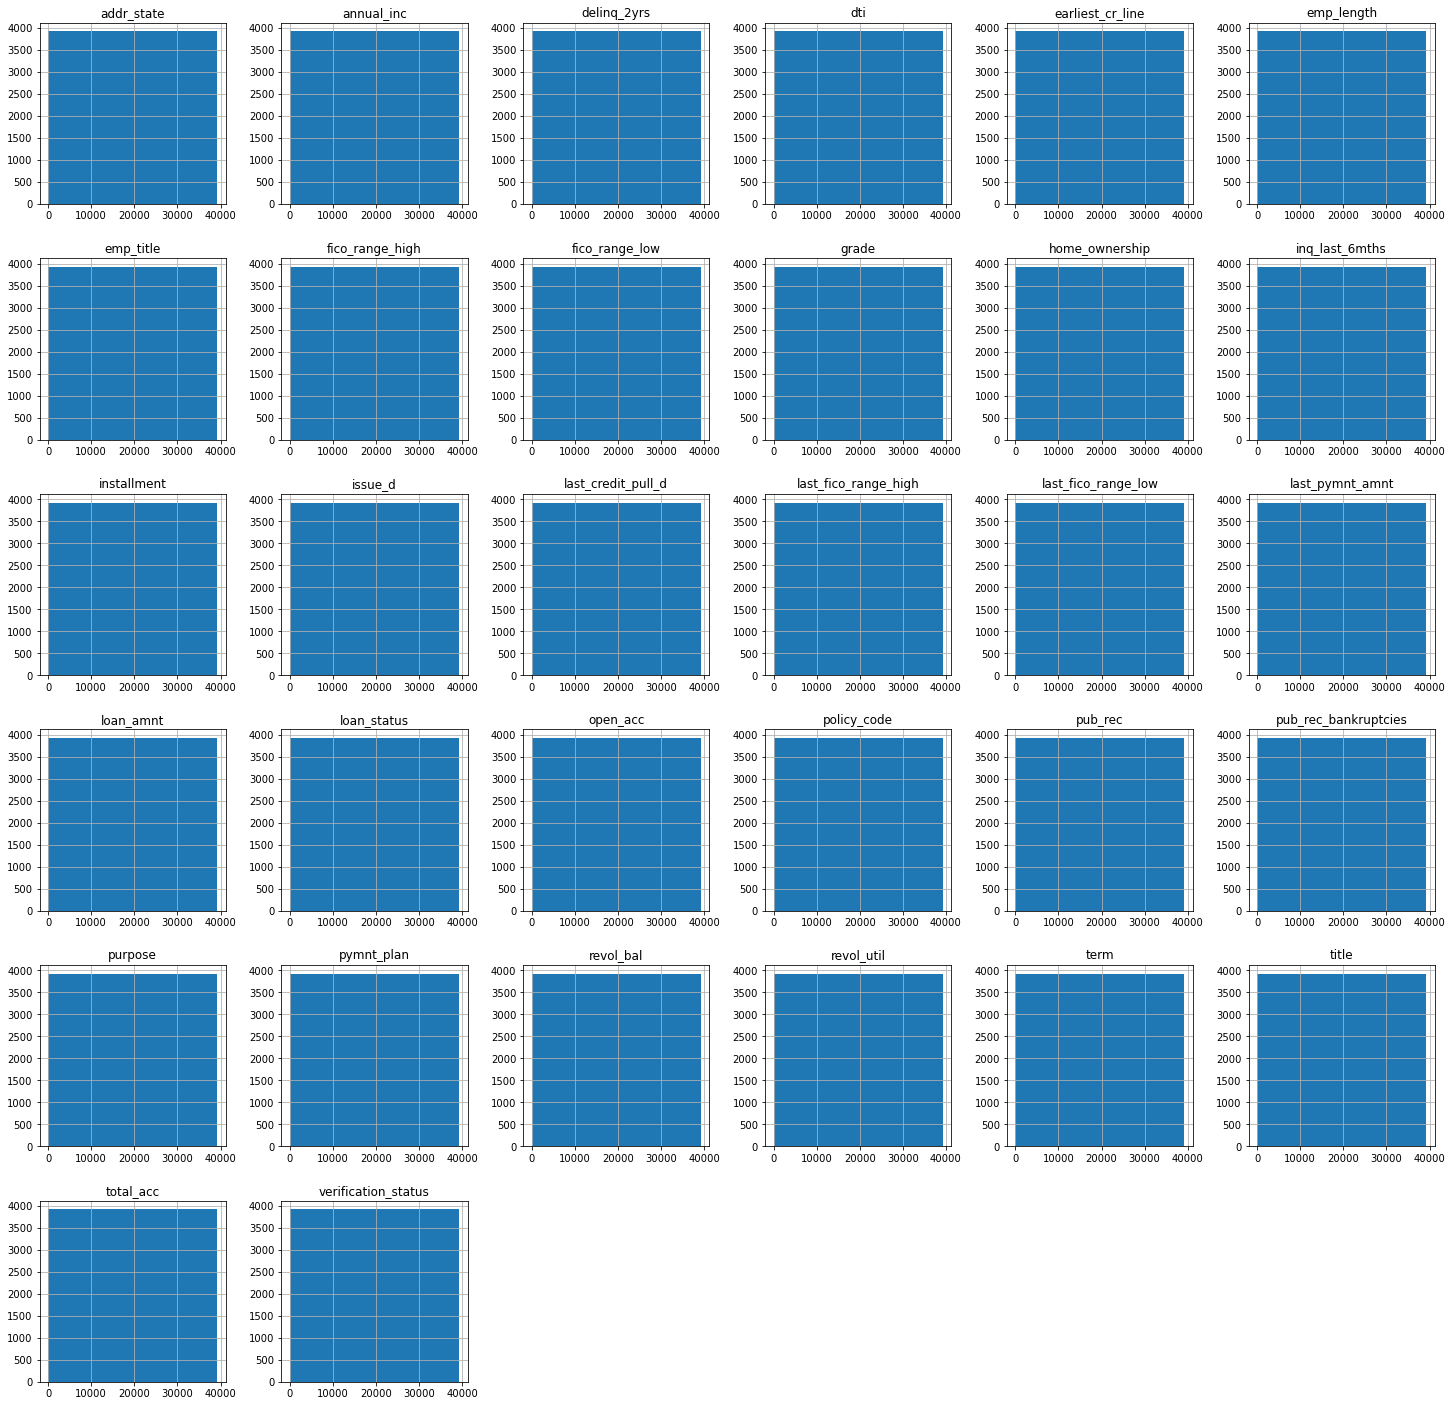

In [139]:
df.hist(figsize=(25, 25))

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39239 entries, 0 to 39785
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             39239 non-null  float64
 1   term                  39239 non-null  float64
 2   installment           39239 non-null  float64
 3   grade                 39239 non-null  float64
 4   emp_title             39239 non-null  float64
 5   emp_length            39239 non-null  float64
 6   home_ownership        39239 non-null  float64
 7   annual_inc            39239 non-null  float64
 8   verification_status   39239 non-null  float64
 9   issue_d               39239 non-null  float64
 10  loan_status           39239 non-null  float64
 11  pymnt_plan            39239 non-null  float64
 12  purpose               39239 non-null  float64
 13  title                 39239 non-null  float64
 14  addr_state            39239 non-null  float64
 15  dti                

In [141]:
#df_ocean_proximity_cat = df['ocean_proximity'].value_counts(normalize=True).map('{:.2%}'.format)
#ex.pie(df_ocean_proximity_cat,names='ocean_proximity',title='ocean_proximity')

In [142]:
df.head()

,loan_amnt,term,installment,grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,policy_code,pub_rec_bankruptcies
0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0,4080.0
1,4079.0,4079.0,4079.0,4079.0,4079.0,4079.0,4079.0,4079.0,4079.0,4079.0,4079.0,4079.0,4079.0,4079.0,4079.0,4079.0,4079.0,4079.0,4079.0,4079.0,4079.0,4079.0,4079.0,4079.0,4079.0,4079.0,4079.0,4079.0,4079.0,4079.0,4079.0,4079.0
2,4078.0,4078.0,4078.0,4078.0,4078.0,4078.0,4078.0,4078.0,4078.0,4078.0,4078.0,4078.0,4078.0,4078.0,4078.0,4078.0,4078.0,4078.0,4078.0,4078.0,4078.0,4078.0,4078.0,4078.0,4078.0,4078.0,4078.0,4078.0,4078.0,4078.0,4078.0,4078.0
3,4077.0,4077.0,4077.0,4077.0,4077.0,4077.0,4077.0,4077.0,4077.0,4077.0,4077.0,4077.0,4077.0,4077.0,4077.0,4077.0,4077.0,4077.0,4077.0,4077.0,4077.0,4077.0,4077.0,4077.0,4077.0,4077.0,4077.0,4077.0,4077.0,4077.0,4077.0,4077.0
5,4076.0,4076.0,4076.0,4076.0,4076.0,4076.0,4076.0,4076.0,4076.0,4076.0,4076.0,4076.0,4076.0,4076.0,4076.0,4076.0,4076.0,4076.0,4076.0,4076.0,4076.0,4076.0,4076.0,4076.0,4076.0,4076.0,4076.0,4076.0,4076.0,4076.0,4076.0,4076.0


In [143]:
df['loan_status'].value_counts()

19975.0    1
9108.0     1
28917.0    1
12362.0    1
13675.0    1
          ..
34456.0    1
35499.0    1
20691.0    1
33965.0    1
2560.0     1
Name: loan_status, Length: 39239, dtype: int64

In [144]:
# Exploring it and understanding what feature each column represents.

# data dictionary 
data_dictionary = pd.read_csv('../data/LCDataDictionary.csv') # Loading in the data dictionary
#print(data_dictionary.shape[0])
#print(data_dictionary.columns.tolist())

In [145]:
data_dictionary = data_dictionary.dropna()

list_columns_all = list(df.columns)

ii = 1
for index, row in data_dictionary.iterrows():
       col1 = row['LoanStatNew']
       col2 = row['Description']

       for icol in list_columns_all:
            if(col1 == icol):
               print(f'# {ii} - {col1}: .......{col2}')
               ii = ii+1

# 1 - addr_state: .......The state provided by the borrower in the loan application
# 2 - annual_inc: .......The self-reported annual income provided by the borrower during registration.
# 3 - delinq_2yrs: .......The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
# 4 - dti: .......A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
# 5 - earliest_cr_line: .......The month the borrower's earliest reported credit line was opened
# 6 - emp_length: .......Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 
# 7 - emp_title: .......The job title supplied by the Borrower when applying for the loan.*
# 8 - fico_range_high: .......The upper boundary range the borrower’s FICO at loan origination belongs to.
# 9 - f

In [146]:
# Generates profile reports from a pandas DataFrame
# pandas_profiling extends the pandas DataFrame with 
# df.profile_report() for quick data analysis
# This request a lot of memory RAM.
# Pandas Profiling on github: https://github.com/pandas-profiling/pandas-profiling
profile = ProfileReport(df, title="Pandas Profiling Report")

In [147]:
# report format html
# A nice way to explore the data. Take a look :)
#!mkdir reports

#profile.to_file("reports/index.html")

# open reports/lending_club_loans.html in a browser

In [148]:
print("saving the file format feather...")

# this is important to do before save in feather format.
df = df.reset_index(drop=True) # reset index pandas before save feather format
df.to_feather('../data/dataset_cleaning.ftr') # save to feather format

release_memory(df)

saving the file format feather...
memory RAM released.


In [149]:
# time of execution in minutes
time_exec_min = round( (time.time() - start_time)/60, 4)

print(f'time of execution (preprocessing/cleaning): {time_exec_min} minutes')
print("the preprocessing is done.")
print("The next step is to do the feature engineering.")
# datetime object containing current date and time
now = datetime.now()

# dd/mm/YY H:M:S
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print(">>> date: ", dt_string)

print("All Done. :)")

time of execution (preprocessing/cleaning): 0.8098 minutes
the preprocessing is done.
The next step is to do the feature engineering.
>>> date:  08/08/2021 21:05:06
All Done. :)
